# INSTALL DEPENDENCIES

In [107]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import cv2

In [108]:
colorImgBgr = cv2.imread(r'../../Downloads/download.png')
grayImg = cv2.imread(r'../../Downloads/puppy.jpeg', cv2.IMREAD_GRAYSCALE)
grayAlb = cv2.imread(r'../../Downloads/albert-einstein_gray.jpg', cv2.IMREAD_GRAYSCALE)
grayAlbAffine = cv2.imread(r'../../Downloads/affine-transformed image.jpg', cv2.IMREAD_GRAYSCALE)
grayImgAffine = cv2.imread(r'../../Downloads/puppy-projective.jpeg', cv2.IMREAD_GRAYSCALE)

In [109]:
import matplotlib as mpl
def displayImageInActualSize(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.show

def displayImageInActualSizeColor(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape[0:2]
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)
    plt.show

# BILINEAR TRANSFORMATION

In [110]:
def f_bilinearInterpolate(row, col, I):
    leftCol = int(col)
    rightCol = leftCol + 1
    widthLeft = col - leftCol
    widthRight = rightCol - col
    topRow = int(row)
    bottomRow = topRow + 1
    widthTop = row - topRow
    widthBottom = bottomRow - row
    if topRow >= 0 and bottomRow < I.shape[0] and leftCol >= 0 and rightCol < I.shape[1]:
        a = I[topRow, leftCol] * widthRight + I[topRow, rightCol] * widthLeft
        b = I[bottomRow, leftCol] * widthRight + I[bottomRow, rightCol] * widthLeft
        g = widthTop * b + widthBottom * a
        return np.uint8(g)
    else:
        return 0

# ROTATION IMPLEMENTATION

In [111]:
def f_getExtents(T, rMax, cMax):
    coords = np.array([[0,0], [0, cMax - 1], [rMax - 1, 0], [rMax - 1, cMax -1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [112]:
def f_transform(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtents(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# AFFINE TRANSFORMATION

In [113]:
def f_getExtentsAffine(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [114]:
def f_transformAffine(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsAffine(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# PROJECTIVE TRANSFORMATION HOMOGRAPHY

In [115]:
def f_getExtentsProjective(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    A_dash = A_dash/A_dash[2,]
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [116]:
def f_transformProjective(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsProjective(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

In [117]:
a = 30
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]])
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)
H = np.array(A)
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

In [118]:
H[2,:] = np.array([0.0001, 0.0001, 1])
H

array([[ 1.12583302e+00, -8.70834875e-02, -2.91651246e+00],
       [ 3.50000000e-01,  7.81217783e-01, -1.74871131e+01],
       [ 1.00000000e-04,  1.00000000e-04,  1.00000000e+00]])

In [119]:
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

In [120]:
I2 = f_transformProjective(H,grayAlb)
plt.imshow(I2,cmap='gray')

In [121]:
def f_getPoints(I,numPts):
    %matplotlib
    fig,ax = plt.subplots(1,figsize=(15,30))
    plt.imshow(I,cmap='gray')
    pts = np.round(np.array(plt.ginput(n=numPts)))
    pts = pts[:,[1,0]].T
    plt.close()
    return pts

In [122]:
pts = f_getPoints(grayImg, 4)
#pts = np.array([[397., 387., 477., 631.], [317., 389., 440., 412.]])

Using matplotlib backend: QtAgg


In [123]:
P = f_getPoints(grayImg, 3)

Using matplotlib backend: QtAgg


In [124]:
P

array([[ 99.,  92., 164.],
       [ 88., 170., 138.]])

In [125]:
P_dash = f_getPoints(grayImgAffine, 3)

Using matplotlib backend: QtAgg


In [126]:
P_dash

array([[ 95.,  80., 127.],
       [ 82., 123., 113.]])

In [127]:
P = np.vstack((P,np.ones((1,3))))

In [128]:
P

array([[ 99.,  92., 164.],
       [ 88., 170., 138.],
       [  1.,   1.,   1.]])

In [129]:
P_dash = np.vstack((P_dash,np.ones((1,3))))

In [130]:
np.linalg.det(P)

-5679.999999999993

In [131]:
A = P_dash.dot(np.linalg.inv(P))

In [132]:
A

array([[ 5.94014085e-01, -1.32218310e-01,  4.78278169e+01],
       [ 8.66197183e-02,  5.07394366e-01,  2.87739437e+01],
       [ 3.46944695e-18,  1.08420217e-18,  1.00000000e+00]])

In [133]:
I2=f_transformProjective(A,grayImg)

In [134]:
plt.imshow(I2,cmap='gray')

In [135]:
plt.imshow(grayImgAffine,cmap='gray')

In [152]:
P = f_getPoints(grayAlb, 5)

Using matplotlib backend: QtAgg


In [153]:
P

array([[402., 398., 398., 406., 492.],
       [328., 386., 456., 505., 439.]])

In [154]:
P_dash =  f_getPoints(grayAlbAffine, 5)

Using matplotlib backend: QtAgg


In [155]:
P_dash

array([[409., 399., 398., 399., 489.],
       [317., 357., 397., 430., 419.]])

In [156]:
P = np.vstack((P,np.ones((1,5))))

In [157]:
P

array([[402., 398., 398., 406., 492.],
       [328., 386., 456., 505., 439.],
       [  1.,   1.,   1.,   1.,   1.]])

In [158]:
P_dash = np.vstack((P_dash,np.ones((1,5))))

In [159]:
P_dash

array([[409., 399., 398., 399., 489.],
       [317., 357., 397., 430., 419.],
       [  1.,   1.,   1.,   1.,   1.]])

In [160]:
A = P_dash.dot(P.T).dot(np.linalg.inv(P.dot(P.T)))

In [161]:
A

array([[ 9.78685957e-01, -6.96540690e-02,  3.79845873e+01],
       [ 3.39916636e-01,  6.23564257e-01, -2.21360214e+01],
       [-6.93889390e-18,  2.42861287e-17,  1.00000000e+00]])

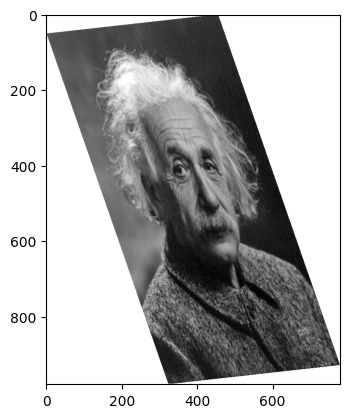

In [162]:
I2=f_transformProjective(A,grayAlb)
%matplotlib inline
plt.imshow(I2, cmap='gray')

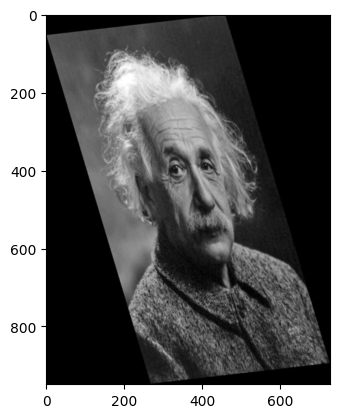

In [163]:
plt.imshow(grayAlbAffine, cmap='gray')

In [164]:
I2=f_transformProjective(A,grayImg)

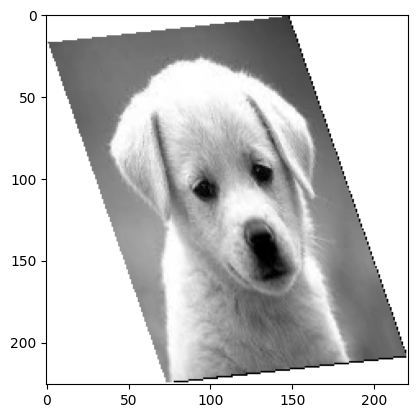

In [165]:
plt.imshow(I2, cmap='gray')